In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.autograd import Variable
import torchvision
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import os
import time
import copy

[Normalization values](https://github.com/kuangliu/pytorch-cifar/issues/19):

In [3]:
cifar10_mean, cifar10_std = [0.4914, 0.4822, 0.4465], [0.247, 0.243, 0.261]

In [4]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(cifar10_mean, cifar10_std)
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(cifar10_mean, cifar10_std)
    ]),
}

In [5]:
import sys
if sys.platform == 'win32':
    data_dir = '_data\cifar10'
else:
    data_dir = os.path.join(os.environ['HOME'], 'hse/nis/cifar10')
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes
print(class_names)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [6]:
device

device(type='cuda', index=0)

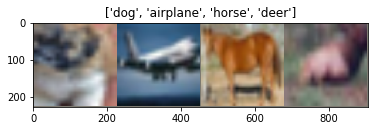

In [7]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean, std = np.array(cifar10_mean), np.array(cifar10_std)
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so t}hat plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [8]:
inputs[0].shape

torch.Size([3, 224, 224])

In [9]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25, verbose=True):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    avg_acc = 0.0

    for epoch in range(num_epochs):
        if verbose:
            print('Epoch {}/{}'.format(epoch, num_epochs - 1))
            print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
                # clear memory to prevent cuda overflow
#                 del inputs
#                 del labels

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if verbose:
                print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                    phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test':
                avg_acc += epoch_acc
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        if verbose:
            print()

    time_elapsed = time.time() - since
    if verbose:
        print('Training complete in {:.0f}m {:.0f}s'.format(
            time_elapsed // 60, time_elapsed % 60))
        print('Best val Acc: {:4f}'.format(best_acc))
    avg_acc /= num_epochs

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, best_acc, avg_acc

In [10]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

# Training multiple models

### Model specific preprocessing

In [11]:
def lock_parameters(model):
    for param in model.parameters():
        param.requires_grad = False

def default_preprocessing(model):
    lock_parameters(model)
    in_ftrs = model.fc.in_features
    model.fc = nn.Linear(in_ftrs, len(class_names))

def vgg_preprocessing(model):
    lock_parameters(model)
    in_ftrs = model.classifier[6].in_features
    model.classifier[6] = nn.Linear(in_ftrs, len(class_names))

def densenet_preprocessing(model):
    lock_parameters(model)
    in_ftrs = model.classifier.in_features
    model.classifier = nn.Linear(in_ftrs, len(class_names))
    
def preprocess(model, is_vgg=False, is_densenet=False):
    if is_vgg:
        vgg_preprocessing(model)
    elif is_densenet:
        densenet_preprocessing(model)
    else:
        default_preprocessing(model)

In [12]:
def multimodel_train(model_data, epochs=25, learning_rate=0.001, m=0.9):
    """Train multiple models given data in specific format"""
    for data in models_data:
        criterion = nn.CrossEntropyLoss()
        model = data['model']
        is_vgg = data['is_vgg']
        is_densenet = data['is_densenet']
        preprocess(model, is_vgg, is_densenet)
        optimizer = None
        if is_vgg:
            optimizer = optim.SGD(model.classifier[6].parameters(), lr=learning_rate, momentum=m, nesterov=True)
        elif is_densenet:
            optimizer = optim.SGD(model.classifier.parameters(), lr=learning_rate, momentum=m, nesterov=True)
        else:
            optimizer = optim.SGD(model.fc.parameters(), lr=learning_rate, momentum=m, nesterov=True)
        exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        model = model.to(device)
        print('Started training: {}'.format(data['model_name']))
        start = time.time()
        trained_model, best_acc, avg_acc = train_model(
            model, criterion, optimizer, exp_lr_scheduler, epochs, verbose=True)
        elapsed = time.time() - start
        print('Trained model: {} | Best Acc: {:.4f} | Avg. Acc: {:.4f}'.format(data['model_name'], best_acc, avg_acc))
        print('Training complete in {:.0f}m {:.0f}s'.format(elapsed // 60, elapsed % 60))
        torch.save(trained_model.state_dict(), 'local_{}_{:.4f}.pth'.format(data['model_name'], best_acc))


In [13]:
models_to_train = {
#     'vgg16_bn': models.vgg16_bn(pretrained=True),  # best test acc: 0.6932
#     'resnet18': models.resnet18(pretrained=True),  # best test acc: 0.6872
    'resnet50': models.resnet50(pretrained=True),
    'vgg19_bn': models.vgg19_bn(pretrained=True),
    'resnet101': models.resnet101(pretrained=True),
    'resnet152': models.resnet152(pretrained=True),
    'densenet161': models.densenet161(pretrained=True)
}

C:\Users\Professional\Anaconda3\lib\site-packages\torchvision\models\densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


In [14]:
models_data = []
for name, model in models_to_train.items():
    models_data.append({'model': model, 'model_name': name, 'is_vgg': 'vgg' in name, 'is_densenet': 'densenet' in name})

In [15]:
multimodel_train(models_data, epochs=25, learning_rate=0.1)

Started training: resnet50
Epoch 0/24
----------
train Loss: 54.0341 Acc: 0.3583
test Loss: 39.8465 Acc: 0.5674

Epoch 1/24
----------
train Loss: 54.0703 Acc: 0.3900
test Loss: 40.6213 Acc: 0.5879

Epoch 2/24
----------
train Loss: 53.6493 Acc: 0.3955
test Loss: 34.2091 Acc: 0.5999

Epoch 3/24
----------
train Loss: 53.1619 Acc: 0.4039
test Loss: 31.6430 Acc: 0.6366

Epoch 4/24
----------
train Loss: 53.7133 Acc: 0.4043
test Loss: 29.9094 Acc: 0.6510

Epoch 5/24
----------
train Loss: 53.3861 Acc: 0.4130
test Loss: 29.8208 Acc: 0.6408

Epoch 6/24
----------
train Loss: 54.4548 Acc: 0.4127
test Loss: 29.6556 Acc: 0.6591

Epoch 7/24
----------
train Loss: 24.1474 Acc: 0.5072
test Loss: 12.7262 Acc: 0.7177

Epoch 8/24
----------
train Loss: 18.6316 Acc: 0.5008
test Loss: 10.0023 Acc: 0.7209

Epoch 9/24
----------
train Loss: 16.4591 Acc: 0.5041
test Loss: 11.3961 Acc: 0.6942

Epoch 10/24
----------
train Loss: 15.5948 Acc: 0.4985
test Loss: 9.9604 Acc: 0.7025

Epoch 11/24
----------
trai

KeyboardInterrupt: 